# Earthquake Statistics

In this notebook we will explore some basics of earthquake statistics including Gutenberg-Richter distributions and Omori aftershock decays.

# 1.0 Magnitude-frequency relations

As you will see in Stein and Wysession, chapter 4.7, the number of earthquakes of a given magnitude generally follows a characteristic distribution, known as the *Gutenberg-Richter* distribution, of the form:

\begin{equation*}
   \log{N} = a - bM,
\end{equation*}

where  $N$ is the number of earthquake with magnitude greater than $M$ occurring in a given time. The two constants, $a$ and $b$, are the intercept and gradient of a linear fit to these data. Lets have a look at some data from New Zealand to start with. Note that we need to ensure that we are only using a single set of self-consistent magnitudes: GeoNet provides multiple different magnitudes for events, including a summary magnitude. We will just compare local magnitudes.

In [1]:
%matplotlib widget

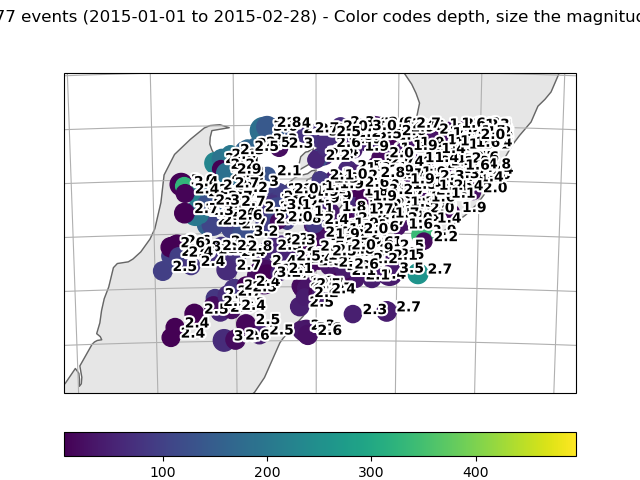

In [2]:
from obspy.clients.fdsn import Client
from obspy import UTCDateTime

# Selecting data from around "central" New Zealand
region = [-42.5, -40.5, 172, 176]
starttime, endtime = UTCDateTime(2015, 1, 1), UTCDateTime(2015, 3, 1)
client = Client("GEONET")

catalog = client.get_events(
    starttime=starttime, endtime=endtime,
    minlatitude=region[0], maxlatitude=region[1],
    minlongitude=region[2], maxlongitude=region[3])

fig = catalog.plot(projection="local", resolution="h")

Nice, that is a useful number of earthquakes. Lets extract consistent magnitudes for each event, and put them into a numpy array for later use:

In [3]:
import numpy as np

magnitudes = np.array([m.mag for ev in catalog for m in ev.magnitudes if m.magnitude_type == "MLv"])
print(f"Found {len(magnitudes)} magnitudes from {len(catalog)} events")

Found 677 magnitudes from 677 events


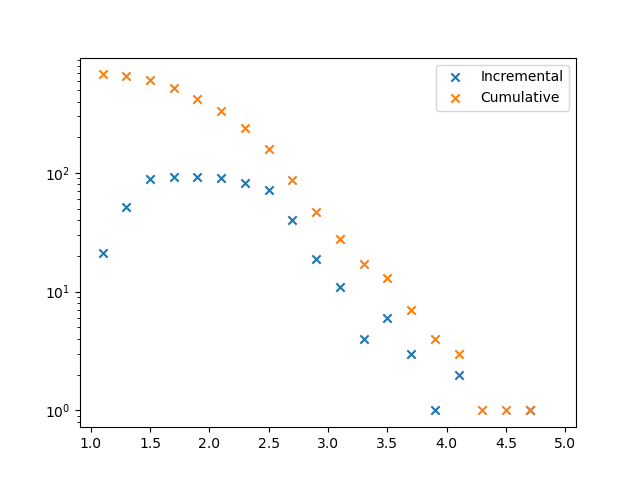

In [4]:
import matplotlib.pyplot as plt

bin_size = 0.2

magnitudes.sort()
min_mag, max_mag = magnitudes[0] // 1, (magnitudes[-1] // 1) + 1
bins = np.arange(min_mag, max_mag + bin_size, bin_size)
# Work out the number of events in each bin
hist, bin_edges = np.histogram(magnitudes, bins=bins)
# Compute the total events below M
cumulative_hist = np.flip(np.flip(hist).cumsum())
bin_mid_points = bin_edges - (bin_size / 2)

fig, ax = plt.subplots()
ax.scatter(bin_mid_points[1:], hist, marker="x", label="Incremental")
ax.scatter(bin_mid_points[1:], cumulative_hist, marker="x", label="Cumulative")
ax.set_yscale("log")

_ = ax.legend()

Hopefully you can see that, for the cumulative version at least, the scatter of magnitudes is nearly linear across most of the magnitude range in this logarithmic Y-scale plot. This is the fundamental observation that Gutenberg and Richter were describing with their simple relation. The fit to this relation in global data is generally found to have a *b-value* (inverse of gradient) of 1, **above some magnitude of completeness**.

The concept of magnitude of completeness (often referred to as $M_c$) is important, and defines the magnitude above which we think that the catalogue contains all the earthquakes that actually occurred in that region and time-span. This limit is defined by a few factors, but it most strongly relates to the detection capabilities of the network, which is a function of station quality, density, detection algorithm, earthquake rate, ... the list is long!. Suffice to say, all catalogues are incomplete, but it is important to know *how* incomplete they are so that we can understand the limitations of those catalogues.

We will think about how we estimate magnitude of completeness in a moment, but to start with lets assume the magnitude of completeness is about 2.5 here and fit all the cumulative data above that value. We can then work out the b-value.

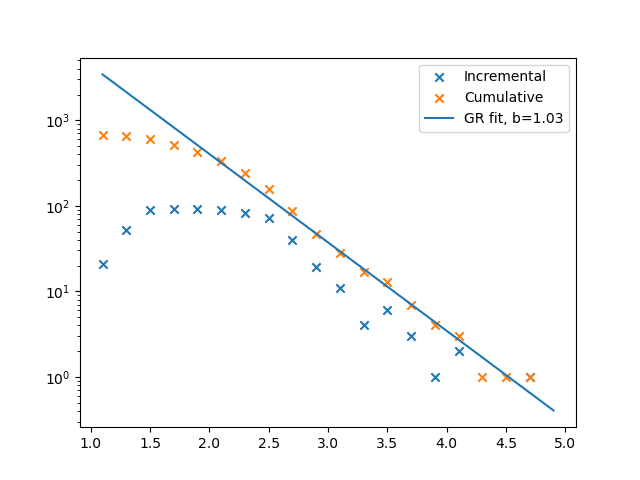

In [5]:
mc = 2.5
mask = np.logical_and(bin_mid_points[1:] >= mc, cumulative_hist > 0)

gr_fit = np.polynomial.Polynomial.fit(
    bin_mid_points[1:][mask], 
    np.log10(cumulative_hist[mask]), 
    deg=1
)
a, b = gr_fit.convert().coef
b *= -1  # Invert for b-value

fitted = 10 ** (a - (b * bin_mid_points[1:]))

fig, ax = plt.subplots()
ax.scatter(bin_mid_points[1:], hist, marker="x", label="Incremental")
ax.scatter(bin_mid_points[1:], cumulative_hist, marker="x", label="Cumulative")
ax.plot(bin_mid_points[1:], fitted, label=f"GR fit, b={b:.2f}")
ax.set_yscale("log")

_ = ax.legend()

You can see that these NZ data have a similar fit to the global dataset presented in Stein and Wysession (Figure 4.7-1). Great! But that is just one time window and one part of the country.

**Exercise:** Pick a different region in NZ and time window (don't select more than a couple of months of data because it will take a while to download the catalogue from GeoNet!) and compute the b-value for that. Does it look like the completeness is the same?

In [6]:
# Your code here

## 1.1 Magnitude of completeness

We have talked about what affects $M_c$, and we can try to fit this in a robust way. One way to do this is to use the "Goodness-of-fit" method discussed by Wiemer & Wyss 2000. We will use a function included in the course utilities to compute the fit quality for a range of b-values.

In [7]:
from gphs445_utilities.statistics import calc_b_value
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import numpy as np

# Selecting data from around "central" New Zealand
region = [-42.5, -40.5, 172, 176]
starttime, endtime = UTCDateTime(2015, 1, 1), UTCDateTime(2015, 6, 1)
client = Client("GEONET")

print("Downloading - this might take a while!")
catalog = client.get_events(
    starttime=starttime, endtime=endtime,
    minlatitude=region[0], maxlatitude=region[1],
    minlongitude=region[2], maxlongitude=region[3])

print("Finished downloading. Extracting magnitudes")
magnitudes = np.array(
    [m.mag for ev in catalog for m in ev.magnitudes 
     if m.magnitude_type == "MLv"])

Finished downloading. Extracting magnitudes


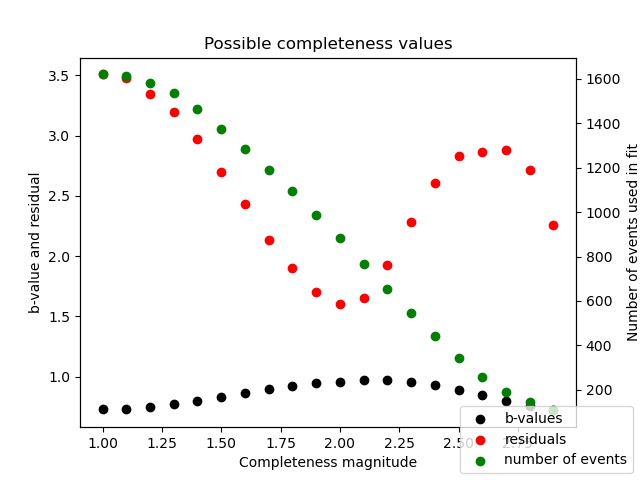

In [8]:
fitted = calc_b_value(magnitudes, completeness=np.arange(1, 3, 0.1), plotvar=True, max_mag=4)

In this plot, higher residuals are better fits to the data. The low residual around $M_c = 2.1$ suggests that our true completeness is above that value, and the most likely completeness is right around 2.5, as we had eye-balled for the smaller three-month catalogue earlier! This means that above $M_{Lv}$ we expect that GeoNet got almost all of the earthquakes in this time-period. Good job. But it also means that below that value we shouldn't expect to have all the earthquakes, so any analysis we do on those smaller earthquakes in inherently limited.

Magnitude of completeness isn't fixed in time though... All the elements that we thought about earlier are time variable (noise, number of stations, earthquake rate, ...) and so we should expect $M_c$ to vary with time. IMHO any paper that looks at catalogue statistics without considering time-varying $M_c$ should be looked at sceptically! [This paper by Hainzl](https://pubs.geoscienceworld.org/ssa/srl/article/87/2A/337/315654/Rate-Dependent-Incompleteness-of-Earthquake?casa_token=JQNmlUIdw24AAAAA:O0TnaBnHTl4k10FDRov5mVrcbM653MuX2bXbGzmAC6UUk8TrqcKnB0WWnEjyBHKLP9UkzsfyGg), earthquake-rate strongly affects catalogue completeness, and must be taken into account when considering the statistics of aftershock sequences (unless a fixed magnitude cut-off is used that is equal to or exceeds the maximum $M_c$).

**Exercise:** Try plotting the magnitude-frequency distribution and computing the magnitude of completeness of the GeoNet catalogue in the same region for the week after the Kaikōura earthquake.

In [9]:
# Your code here.

# 2.0 Aftershock decay

Earthquakes are often clustered in space and time, and this is particularly obvious during mainshock-aftershock sequences, where a large magnitude earthquake is followed by many smaller aftershocks. The rate of aftershock production decays with time, following a relationship first described by Fusakihi Omori using the equation:

\begin{equation}
    n(t) = \frac{C}{(K+t)^1}
\end{equation}

which was then modified by Utsu to make the modified Omori law, or Omori-Utsu law:

\begin{equation}
    n(t) = \frac{C}{(K+t)^p}
\end{equation}

where $n(t)$ is the rate of aftershocks at a given time ($t$) after a mainshock, $C$ is the productivity which is related to the mainshock magnitude, $K$ is a case-dependent time-scale (effectively a delay in productivity) and $p$ is usually close to 1.

We can see the relation between aftershock rate and time in some of the examples from around New Zealand. For these examples we do not need the full GeoNet catalogue, although this does mean that we might be getting a mixture of magnitude types (which as you know is bad!), but for speed we will just get a simplified catalogue from GeoNet's QuakeSearch using a web-scraper:


In [10]:
import numpy as np
from gphs445_utilities.get_data import get_geonet_quakes

from obspy import UTCDateTime


# Selecting data from around "central" New Zealand
region = [-42.5, -40.5, 172, 176]
starttime, endtime = UTCDateTime(2016, 11, 13), UTCDateTime(2016, 12, 13)

event_info = get_geonet_quakes(
    start_time=starttime, end_time=endtime,
    min_latitude=region[0], max_latitude=region[1],
    min_longitude=region[2], max_longitude=region[3])

Using query: https://quakesearch.geonet.org.nz/csv?bbox=172,-42.5,176,-40.5&minmag=0.0&maxmag=9.0&mindepth=0.0&maxdepth=500.0&startdate=2016-11-13T00:00:00&enddate=2016-12-13T00:00:00


In [11]:
# Get the magnitudes and times as arrays
magnitudes = np.array(event_info["magnitude"])
times = np.array(event_info["origintime"])

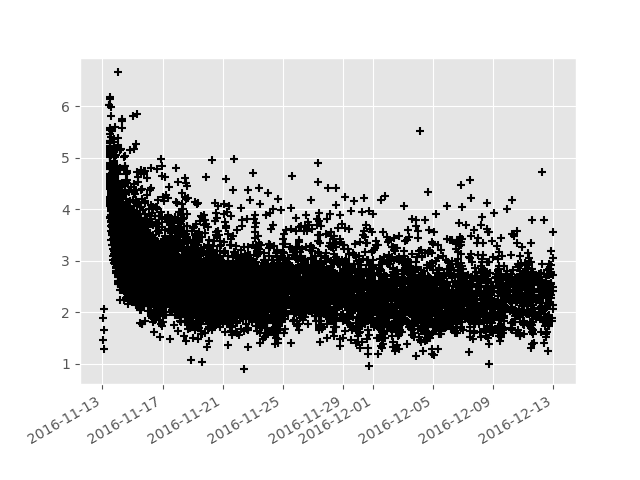

In [12]:
# Plot
import matplotlib.pyplot as plt
plt.style.use("ggplot")

fig, ax = plt.subplots()
ax.scatter(times, magnitudes, marker="+", color="k")
fig.autofmt_xdate()

You can see clearly in the plot above that there are a lot more earthquakes early in the aftershock sequence, and a lot more large magnitude earthquakes early in the sequence - this follows the Gutenberg-Richter law: if you have more earthquakes generally then you should expect to have increased earthquake rates across the magnitude range. 

Bearing in mind what you know of the Guternberg-Richter relation, and the dependence of catalogue completeness on earthquake rate you should also be able to explain the strange reduction in magnitude $<=$ 3 earthquakes early in the sequence. This is an artifact of the completeness limitations of the catalogue: there are so many earthquakes happening close in time that the smaller earthquakes are missed. This is either due to the amplitudes being so high that the amplitude based detectors used to make this catalogue are saturated and cannot detect the smaller variations in amplitude associated with the smaller earthquakes, or because the earthquake waveforms actually overlap each other in time. Matched-filter techniques are better at resolving catalogues during these high-rate sequences, but they still suffer from some saturation affects at high earthquake rates (and have other down-sides!).

We can also look at the cumulative number of aftershocks with time to see how the earthquake production rate changes with time:

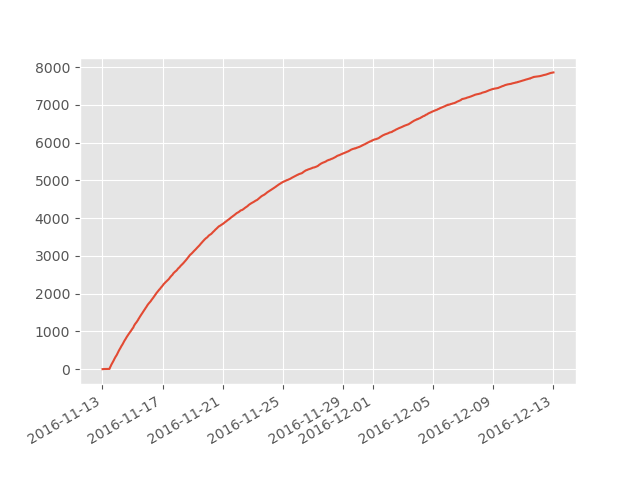

In [13]:
fig, ax = plt.subplots()
cum_count = np.arange(len(times))
ax.plot(times, cum_count)
fig.autofmt_xdate()

We have already mentioned that we shouldn't use incomplete catalogues for statistics. When considering Omori decays we should only fit the complete part of the catalogue. The first few hours are very incomplete, but beyond that, the magnitude of completeness of this catalogue is about 3.0:

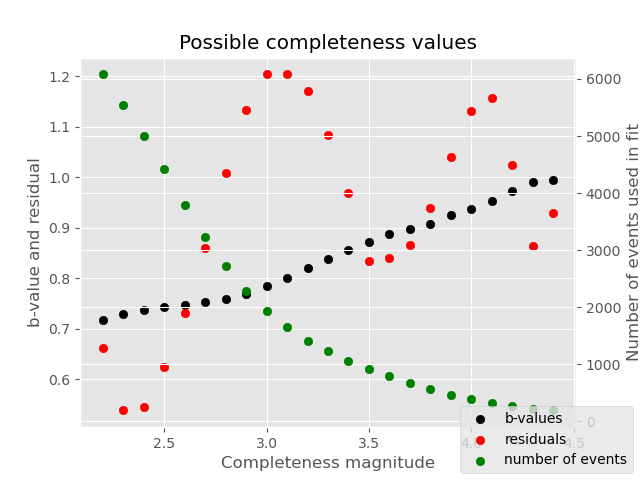

In [14]:
from gphs445_utilities.statistics import calc_b_value, freq_mag

_ = calc_b_value(magnitudes=magnitudes, completeness=np.arange(2.2, 4.5, 0.1))

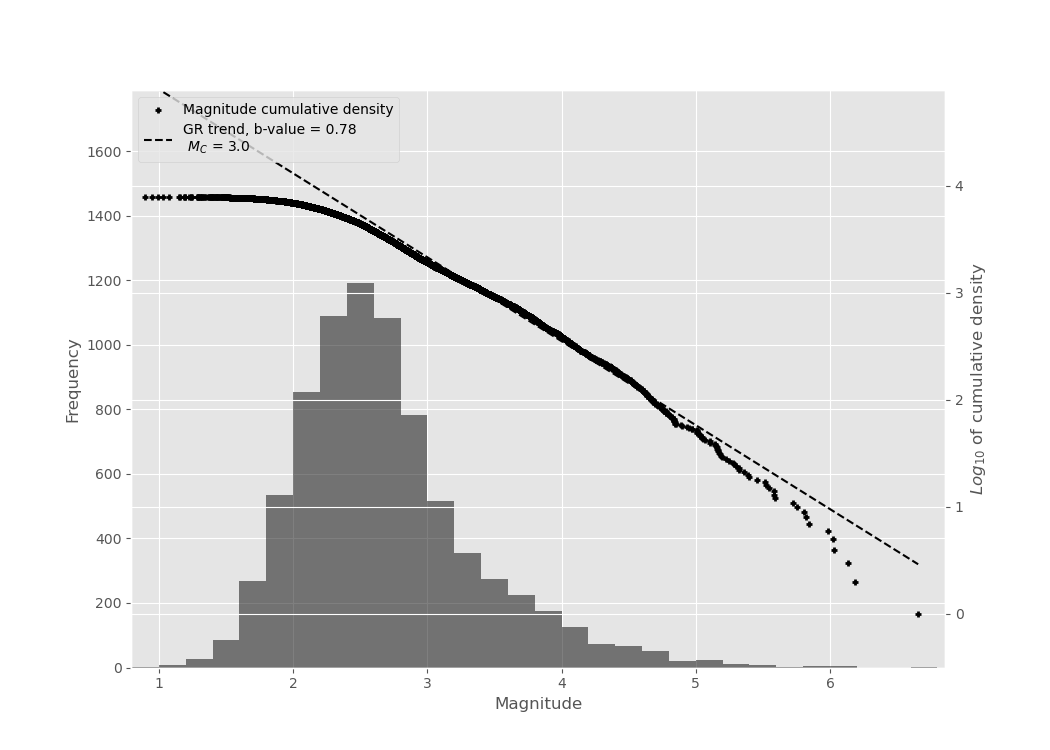

In [15]:
fig = freq_mag(magnitudes, 3.0, 7.0, show=False, return_figure=True)

Given that, we should extract the earthquakes of magnitude $>=$ 3.0 and work on those:

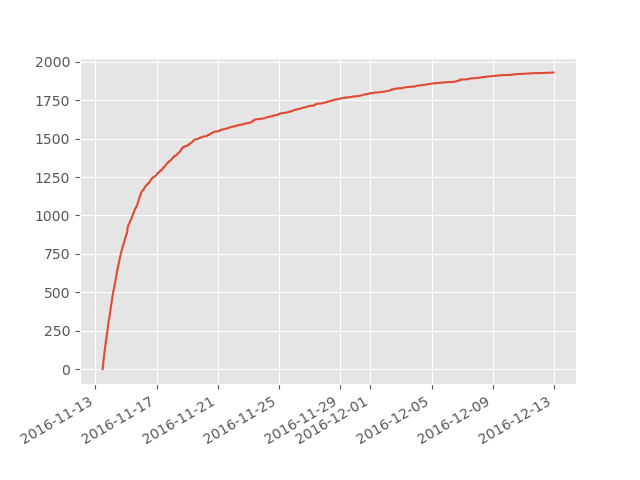

In [16]:
magnitude_mask = event_info["magnitude"] >= 3.0
complete_magnitudes = event_info["magnitude"][magnitude_mask]
complete_times = event_info["origintime"][magnitude_mask]

fig, ax = plt.subplots()
cum_count = np.arange(len(complete_times))
ax.plot(complete_times, cum_count)
fig.autofmt_xdate()

That is quite different! the rate of $M>=3$ earthquake falls off dramatically within the first week. Lets replot that as the hourly rate of earthquakes $M>=3$:

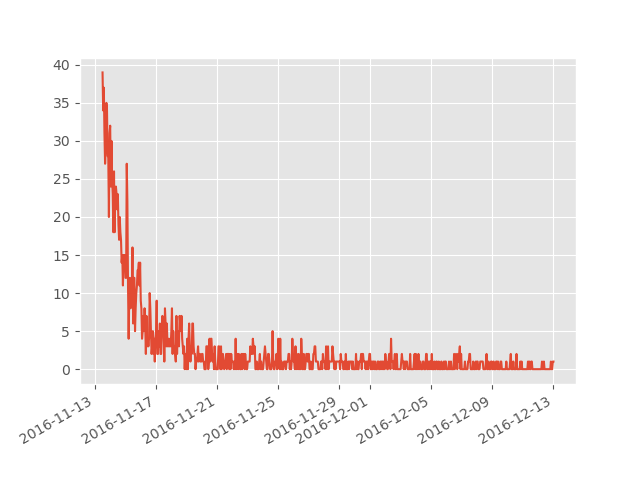

In [17]:
# We need to convert to seconds now for the maths
import datetime as dt
mainshock_time = dt.datetime(2016, 11, 13, 11, 2, 56)
times_hours = np.array([(t - mainshock_time).total_seconds() for t in complete_times]) / 3600

hourly_rate, hours = np.histogram(
    times_hours, 
    bins=np.arange(times_hours.min(), times_hours.max() + 1, 1))
hour_times = [mainshock_time + dt.timedelta(hours=h) for h in hours[1:]]

fig, ax = plt.subplots()
ax.plot(hour_times, hourly_rate)
fig.autofmt_xdate()

Okay, now we want to try and fit the aftershock rates with an Omori decay. Once we have done that we can start to make basic forecasts for the rate of earthquakes of magnitude $>=$ 3 at any time after the mainshock. This kind of statistical analysis is at the heart of how we forecast earthquakes, although there are now more sophisticated (both computationally, and using more advanced theory) methods of forecasting earthquakes. If you are interested you should have a look at the [forecasts](https://www.geonet.org.nz/earthquake/forecast/kaikoura) that GeoNet runs.

We will fit the Omori law using [scipy.optimize.curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html), where we can provide an arbitrary function that describes a relation between two parameters and invert for the best fit. To do that we first need to define the function that maps between time and rate:

In [18]:
def omori(t, k, p, c):
    return c / ((k + t) ** p)

Now we should just have to call scipy's `curve_fit` function. However, we know that our catalogue isn't complete to M 3 for the early part of the sequence. It is common to not try to fit this early part of the sequence when the catalogue is most incomplete. In the example below we skip the first 24 hours of earthquakes (which is most of the data!) to remove the most incomplete part of the catalogue. We would be able to get better forecasts more rapidly if we could improve catalogue completeness in the first few hours after a mainshock.

You can experiment with how much data you remove to get this fit:

In [19]:
import warnings
from scipy.optimize import curve_fit

start_hour = 24
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    params_fitted, cov = curve_fit(
        omori, hours[start_hour:], hourly_rate[start_hour-1:])

k, p, c = params_fitted
print(f"k: {k:.2f}, p: {p:.2f}, c: {c:.1f}")

k: 12.88, p: 1.49, c: 4609.5


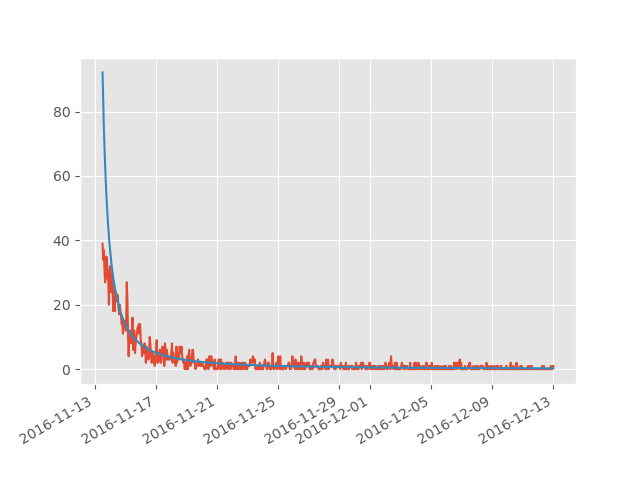

In [20]:
hourly_rate_fitted = [omori(t, k=k, c=c, p=p) for t in hours[1:]]

fig, ax = plt.subplots()
ax.plot(hour_times, hourly_rate)
ax.plot(hour_times, hourly_rate_fitted)
fig.autofmt_xdate()

Sweet, that mostly fits! You can see that the curve doesn't get to zero at any point, so what should we expect the rate of $M>=3$ earthquakes to be based on this simple model two years after the earthquake?

In [21]:
total_hours = 2 * 365.25 * 24
rate = omori(total_hours, k=k, p=p, c=c)
print(f"The rate {total_hours} after the mainshock is expected to be {rate:.6f} "
      f"per hour or {rate * 24 * 7:.3f} per week")

The rate 17532.0 after the mainshock is expected to be 0.002278 per hour or 0.383 per week


Now it is your turn, you have two exercises to do to get a feel for the stability of these results:
1. Try fitting Omori parameters for Kaikōura, but with a magnitude of completeness of 2.
2. Try the whole process (including determining the magnitude of completeness to use) for a different mainshock in New Zealand. Compare the parameters that you resolve.

In [22]:
# Your work here.